# Connexion + test DB

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

POSTGRES_HOST = os.getenv("POSTGRES_HOST")
POSTGRES_PORT = os.getenv("POSTGRES_PORT")
POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")

assert POSTGRES_HOST and POSTGRES_DB and POSTGRES_USER and POSTGRES_PASSWORD, "Variables d'environnement PostgreSQL manquantes"

engine = create_engine(
    f"postgresql+psycopg2://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}",
    pool_pre_ping=True
)

def read_sql(q: str, params=None):
    with engine.connect() as conn:
        return pd.read_sql(text(q), conn, params=params or {})


In [2]:
read_sql("SELECT COUNT(*) AS trips FROM fact_trip;")

,trips
0,5930514


# Sanity checks

## 1. Qualité des données – Valeurs nulles

In [3]:
read_sql("""
SELECT
    SUM(CASE WHEN pickup_date IS NULL THEN 1 ELSE 0 END) AS null_pickup_date,
    SUM(CASE WHEN pickup_time IS NULL THEN 1 ELSE 0 END) AS null_pickup_time,
    SUM(CASE WHEN pickup_location_id IS NULL THEN 1 ELSE 0 END) AS null_pickup_location,
    SUM(CASE WHEN dropoff_location_id IS NULL THEN 1 ELSE 0 END) AS null_dropoff_location,
    SUM(CASE WHEN total_amount IS NULL THEN 1 ELSE 0 END) AS null_total_amount
FROM fact_trip;
""")


,null_pickup_date,null_pickup_time,null_pickup_location,null_dropoff_location,null_total_amount
0,0,0,0,0,0


### Vérification des valeurs négatives

In [4]:
read_sql("""
SELECT
    SUM(CASE WHEN total_amount < 0 THEN 1 ELSE 0 END) AS negative_total_amount,
    SUM(CASE WHEN trip_distance < 0 THEN 1 ELSE 0 END) AS negative_trip_distance,
    SUM(CASE WHEN passenger_count < 0 THEN 1 ELSE 0 END) AS negative_passenger_count
FROM fact_trip;
""")


,negative_total_amount,negative_trip_distance,negative_passenger_count
0,0,0,0


# KPIs globaux

## 2. Indicateurs globaux

In [5]:
read_sql("""
SELECT
    COUNT(*) AS trips,
    SUM(total_amount) AS total_revenue,
    AVG(total_amount) AS avg_total_amount,
    AVG(trip_distance) AS avg_trip_distance,
    AVG(passenger_count) AS avg_passenger_count
FROM fact_trip;
""")

,trips,total_revenue,avg_total_amount,avg_trip_distance,avg_passenger_count
0,5930514,1.624411e+08,27.390737,3.863167,1.358102


## 3. Analyse temporelle

### Nombre de courses par jour

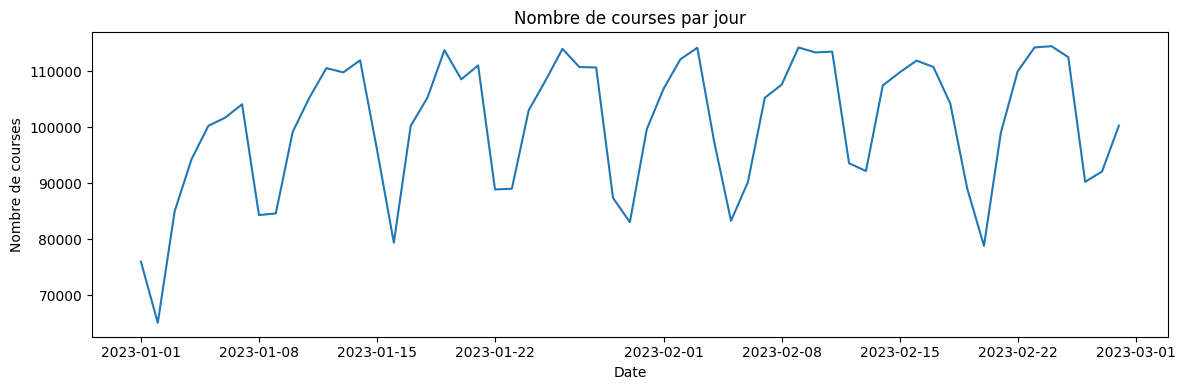

In [6]:
df_daily = read_sql("""
SELECT
    pickup_date,
    COUNT(*) AS trips
FROM fact_trip
GROUP BY pickup_date
ORDER BY pickup_date;
""")

df_daily["pickup_date"] = pd.to_datetime(df_daily["pickup_date"])

plt.figure(figsize=(12, 4))
plt.plot(df_daily["pickup_date"], df_daily["trips"])
plt.title("Nombre de courses par jour")
plt.xlabel("Date")
plt.ylabel("Nombre de courses")
plt.tight_layout()
plt.show()

### Nombre de courses par année (contrôle périmètre)

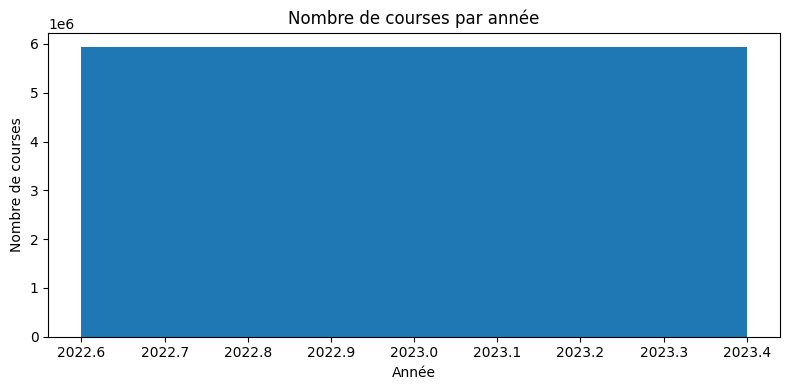

In [7]:
df_yearly = read_sql("""
SELECT
    EXTRACT(YEAR FROM pickup_date) AS year,
    COUNT(*) AS trips
FROM fact_trip
GROUP BY year
ORDER BY year;
""")

plt.figure(figsize=(8, 4))
plt.bar(df_yearly["year"].astype(int), df_yearly["trips"])
plt.title("Nombre de courses par année")
plt.xlabel("Année")
plt.ylabel("Nombre de courses")
plt.tight_layout()
plt.show()

### Heures de pointe

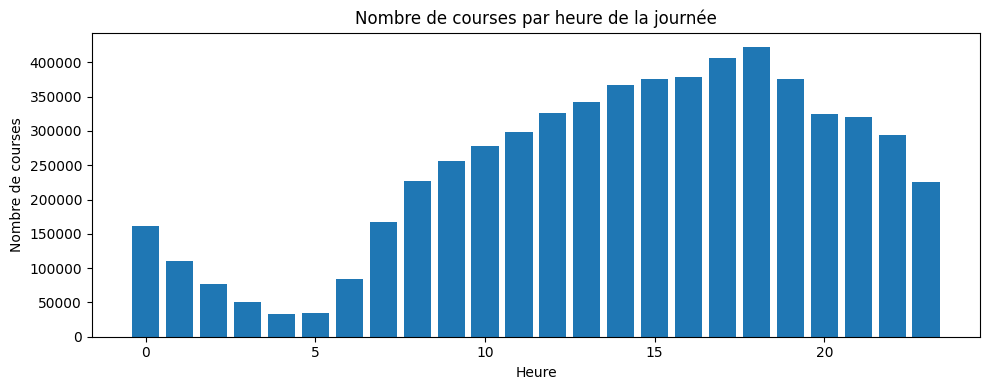

In [8]:
df_hourly = read_sql("""
SELECT
    t.hour,
    COUNT(*) AS trips
FROM fact_trip f
JOIN dim_time t
  ON f.pickup_time = t.time_id
GROUP BY t.hour
ORDER BY t.hour;
""")

plt.figure(figsize=(10,4))
plt.bar(df_hourly["hour"], df_hourly["trips"])
plt.title("Nombre de courses par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Nombre de courses")
plt.tight_layout()
plt.show()

## 4. Analyse géographique

### Top zones de départ (lisible métier)

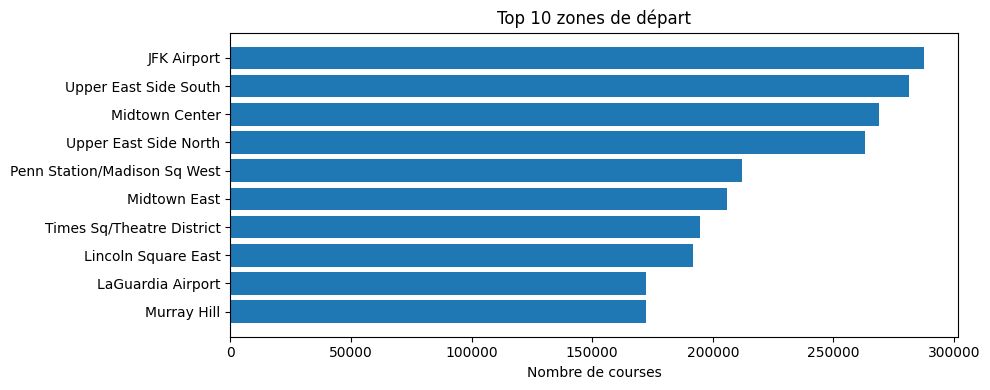

In [9]:
df_pickup_zones = read_sql("""
SELECT
    l.borough,
    l.zone,
    COUNT(*) AS trips
FROM fact_trip f
JOIN dim_location l
  ON f.pickup_location_id = l.location_id
GROUP BY l.borough, l.zone
ORDER BY trips DESC
LIMIT 10;
""")

plt.figure(figsize=(10,4))
plt.barh(df_pickup_zones["zone"], df_pickup_zones["trips"])
plt.gca().invert_yaxis()
plt.title("Top 10 zones de départ")
plt.xlabel("Nombre de courses")
plt.tight_layout()
plt.show()

## 5. Analyse des types de paiement

### Nombre de courses par type de paiement

In [10]:
df_payment_count = read_sql("""
SELECT
    p.payment_description,
    COUNT(*) AS trips
FROM fact_trip f
JOIN dim_payment_type p
  ON f.payment_type_id = p.payment_type_id
GROUP BY p.payment_description
ORDER BY trips DESC;
""")

df_payment_count

,payment_description,trips
0,Credit card,4720934
1,Cash,997932
2,Flex Fare,148450
3,Dispute,36247
4,No charge,26951


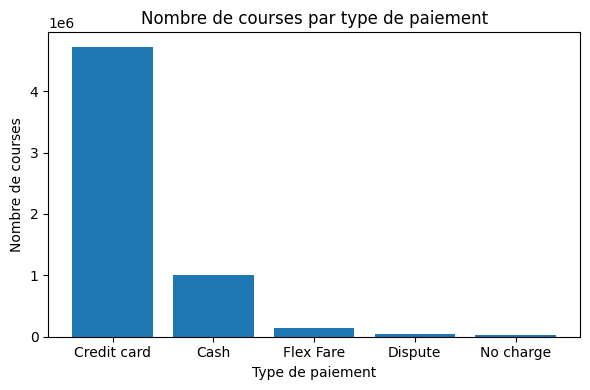

In [11]:
plt.figure(figsize=(6,4))
plt.bar(df_payment_count["payment_description"], df_payment_count["trips"])
plt.title("Nombre de courses par type de paiement")
plt.xlabel("Type de paiement")
plt.ylabel("Nombre de courses")
plt.tight_layout()
plt.show()

## Chiffre d’affaires par type de paiement

In [12]:
df_payment_revenue = read_sql("""
SELECT
    p.payment_description,
    SUM(f.total_amount) AS revenue
FROM fact_trip f
JOIN dim_payment_type p
  ON f.payment_type_id = p.payment_type_id
GROUP BY p.payment_description
ORDER BY revenue DESC;
""")

df_payment_revenue

,payment_description,revenue
0,Credit card,1.332708e+08
1,Cash,2.351470e+07
2,Flex Fare,4.248503e+06
3,Dispute,8.585190e+05
4,No charge,5.486521e+05


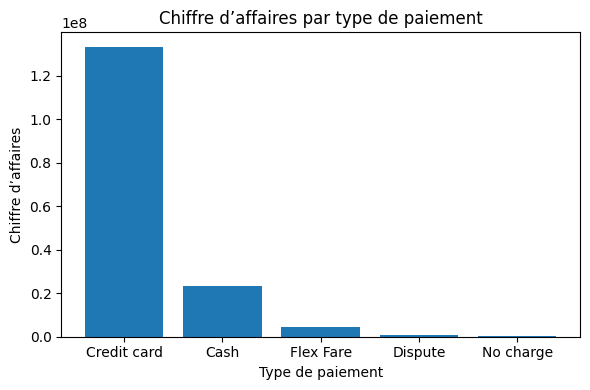

In [13]:
plt.figure(figsize=(6,4))
plt.bar(df_payment_revenue["payment_description"], df_payment_revenue["revenue"])
plt.title("Chiffre d’affaires par type de paiement")
plt.xlabel("Type de paiement")
plt.ylabel("Chiffre d’affaires")
plt.tight_layout()
plt.show()

## 6. Relation distance / montant

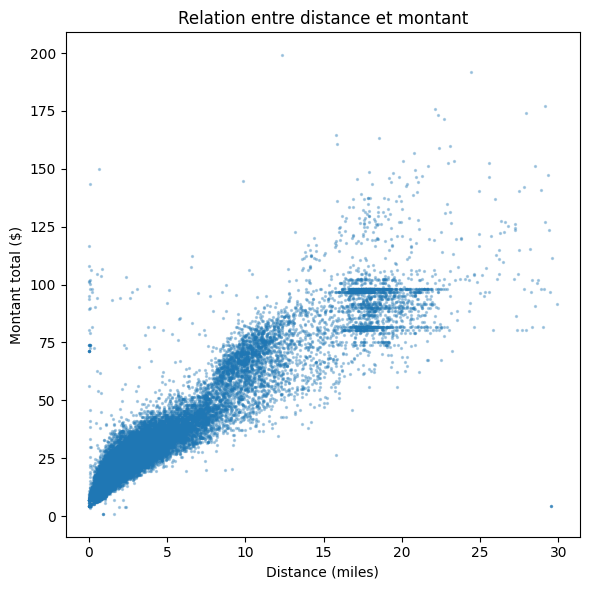

In [14]:
df_distance_amount = read_sql("""
SELECT
    trip_distance,
    total_amount
FROM fact_trip
WHERE trip_distance > 0
  AND trip_distance <= 30
  AND total_amount > 0
  AND total_amount <= 200
LIMIT 50000;
""")

plt.figure(figsize=(6,6))
plt.scatter(
    df_distance_amount["trip_distance"],
    df_distance_amount["total_amount"],
    s=2,
    alpha=0.3
)
plt.xlabel("Distance (miles)")
plt.ylabel("Montant total ($)")
plt.title("Relation entre distance et montant")
plt.tight_layout()
plt.show()

## Interprétation générale

L’analyse exploratoire montre que les données sont globalement propres et cohérentes sur la période étudiée (janvier et février 2023).  
Les contrôles réalisés n’ont pas mis en évidence de valeurs aberrantes majeures (valeurs négatives, champs manquants), ce qui confirme que le nettoyage et les filtrages appliqués en amont dans le pipeline ont été efficaces.

Les indicateurs globaux (montant moyen, distance moyenne, nombre de passagers) sont stables et cohérents avec ce que l’on peut attendre de courses de taxi à New York.  
L’évolution temporelle des courses met en évidence une activité régulière au quotidien, ainsi que des heures de pointe marquées dans la journée, correspondant aux usages urbains classiques.

Les analyses géographiques et par type de paiement deviennent lisibles grâce à l’enrichissement du Data Warehouse avec les référentiels métier TLC.  
On observe notamment une concentration des départs dans certaines zones et une forte domination du paiement par carte bancaire, aussi bien en volume qu’en chiffre d’affaires.

Enfin, la relation entre la distance parcourue et le montant facturé est logique et ne révèle pas d’anomalies significatives.

Cette EDA permet donc de bien comprendre le contenu du Data Warehouse et d’identifier des indicateurs simples, pertinents et directement exploitables pour la mise en place du tableau de bord Streamlit.
